In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import json
import graphviz

In [2]:
animalData = pd.read_csv('train.csv')
animalData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
petIDs = np.array(animalData["PetID"])
magnitude = []
score = []

# loop through IDs, do some math with the magnitudes and score and save that into a Numpy array, then add it to the animals Database
for id in petIDs:
  try: 
    with open("./train_sentiment/" + id + '.json') as json_file:
      itemData = json.load(json_file)
      magnitude.append(itemData["documentSentiment"]["magnitude"])
      score.append(itemData["documentSentiment"]["score"])
  except:
    magnitude.append(0.0)
    score.append(0.0)
    pass

jsonData = {"Magnitude" : magnitude, "Score" : score}
animalData = animalData.join(pd.DataFrame(data = jsonData))

In [4]:
#create empty list
descriptionWords = []

# Combines words with similar meaning together
stemmer = PorterStemmer()

# Removes words like "it", "the", etc.
sw = stopwords.words("english")

for i in animalData["Description"]:
    i = str(i)
    if i == 'nan':
        i = 'blank'
    text = i.lower()
    words = word_tokenize(i)
    words = [word for word in words if word not in sw]
    words = [stemmer.stem(word) for word in words]
    words = [w for w in words if len(w) > 3]
    words = ' '.join(str(word) for word in words)
    descriptionWords.append(words)
    
animalData = animalData.join(pd.DataFrame(data = {"DescriptionWords" : np.array(descriptionWords)}))

In [5]:
count1 = Counter(" ".join(animalData["DescriptionWords"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of description", 1 : "count"})       

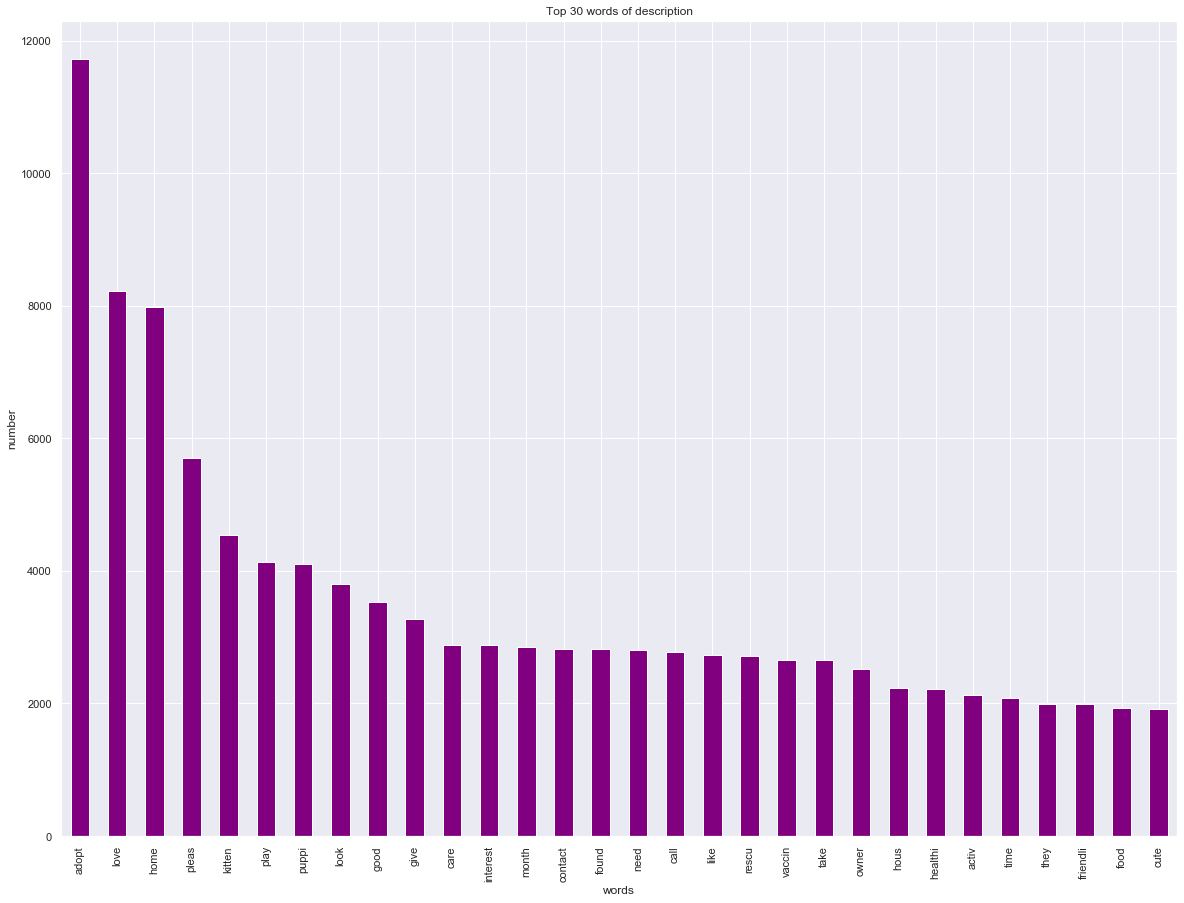

In [6]:
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data1["words of description"]))
plt.xticks(y_pos, data1["words of description"])
plt.title('Top 30 words of description')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [7]:
alist = ["good","play","love","care","vaccin",'friendli',"healthi","activ","cute","rescu"]
blist =[]

for words in animalData['DescriptionWords']:
    words = word_tokenize(words)
    blist.append(len([word for word in words if word in alist]))
    
animalData = animalData.join(pd.DataFrame(data = {"GoodWords" : np.array(blist)}))
animalData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Magnitude,Score,DescriptionWords,GoodWords
0,2,Nibble,3,299,0,1,1,7,0,1,...,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2.4,0.3,nibbl month ball cute energet play rescu coupl...,5
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.7,-0.2,found alon yesterday near apart shake bring ho...,1
2,1,Brisco,1,307,0,1,2,7,0,2,...,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,3.7,0.2,their pregnant mother dump irrespons owner roa...,2
3,1,Miko,4,307,0,2,1,2,0,2,...,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.9,0.9,good guard alert activ obedi wait good master ...,3
4,1,Hunter,1,307,0,1,1,0,0,2,...,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,3.7,0.6,handsom cute adopt play seen puppi love nibbl ...,7


In [8]:
predictors = animalData.drop(["Name", "State", "RescuerID", "Description","DescriptionWords", "PetID", "AdoptionSpeed", "Breed1", "Breed2", "Color1", "Color2", "Color3"], axis = 1)
response = pd.DataFrame(animalData["AdoptionSpeed"])
predictors.head()

,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,Magnitude,Score,GoodWords
0,2,3,1,1,1,2,2,2,1,1,100,0,1.0,2.4,0.3,5
1,2,1,1,2,2,3,3,3,1,1,0,0,2.0,0.7,-0.2,1
2,1,1,1,2,2,1,1,2,1,1,0,0,7.0,3.7,0.2,2
3,1,4,2,2,1,1,1,2,1,1,150,0,8.0,0.9,0.9,3
4,1,1,1,2,1,2,2,2,1,1,0,0,3.0,3.7,0.6,7


In [9]:
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size = 0.25)

# Decision Tree

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.4196905016008538

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.37396639103761004



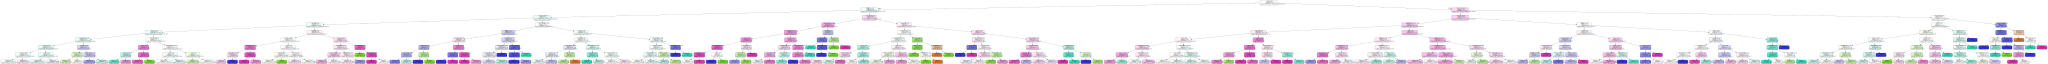

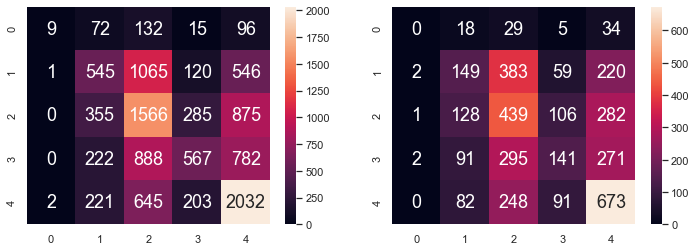

In [10]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 8)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model
#max depth increases the number of variables to be considered, making the classification accuracy better

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

results = pd.DataFrame(data = {"DecTree" : y_test_pred})

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

graphviz.Source(treedot)

# Random Forest

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.37139807897545357

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.3769005068018138



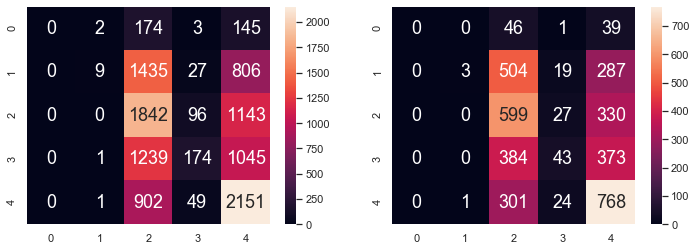

In [11]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.values.ravel())

# Predict AdoptionSpeed 
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

results = results.join(pd.DataFrame(data = {"RForest" : y_test_pred}))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rforest.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.31750266808964783

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.3339557215257402



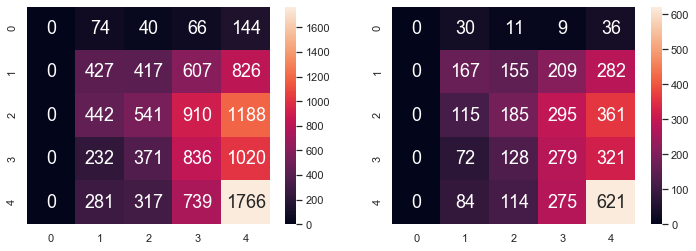

In [12]:
svcModel = LinearSVC()
svcModel.fit(X_train, y_train.values.ravel())

y_train_pred = svcModel.predict(X_train)
y_test_pred = svcModel.predict(X_test)

results = results.join(pd.DataFrame(data = {"SVC" : y_test_pred}))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", svcModel.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", svcModel.score(X_test, y_test))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Train on 11244 samples
Epoch 1/15
11244/11244 [==============================] - 1s 45us/sample - loss: 1.9134 - accuracy: 0.2849
Epoch 2/15
11244/11244 [==============================] - 0s 30us/sample - loss: 1.4865 - accuracy: 0.3072
Epoch 3/15
11244/11244 [==============================] - 0s 25us/sample - loss: 1.4754 - accuracy: 0.3200
Epoch 4/15
11244/11244 [==============================] - 0s 24us/sample - loss: 1.4583 - accuracy: 0.3342
Epoch 5/15
11244/11244 [==============================] - 0s 24us/sample - loss: 1.4489 - accuracy: 0.3421
Epoch 6/15
11244/11244 [==============================] - 0s 24us/sample - loss: 1.4422 - accuracy: 0.3448
Epoch 7/15
11244/11244 [==============================] - 0s 26us/sample - loss: 1.4341 - accuracy: 0.3509
Epoch 8/15
11244/11244 [==============================] - 0s 28us/sample - loss: 1.4383 - accuracy: 0.3534
Epoch 9/15
11244/11244 [==============================] - 0s 25us/sample - loss: 1.4370 - accuracy: 0.3533
Epoch 10/15
11

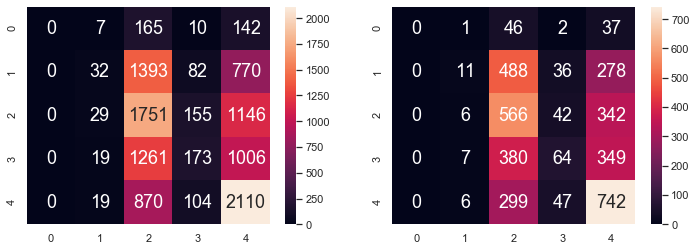

In [13]:
model = keras.Sequential([
    keras.layers.Dense(16, input_shape = (16,)),
    keras.layers.Dense(8, activation = "elu"),
    keras.layers.Dense(8, activation = "selu"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.fit(X_train, y_train, epochs = 15)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
matrix = confusion_matrix(y_train, y_train_pred)
sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))
    
results = results.join(pd.DataFrame(data = {"Keras" : y_test_pred}))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

matrix = confusion_matrix(y_test, y_test_pred)
sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [14]:
results.head()

,DecTree,RForest,SVC,Keras
0,2,2,1,2
1,4,4,3,4
2,2,2,4,4
3,1,2,4,2
4,4,4,1,4


Goodness of Fit
Classification Accuracy 	: 0.3814350493464924



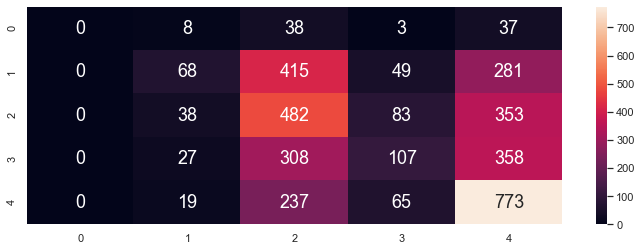

In [15]:
final = []

for row in results.itertuples():
    row = [row[1], row[2], row[3], row[4]]
    row = Counter(row).most_common(1)
    final.append(row[0][0])
    
print("Goodness of Fit")
print("Classification Accuracy \t:", accuracy_score(y_test, final))
print()

f, axes = plt.subplots(1, 1, figsize=(12, 4))
matrix = confusion_matrix(y_test, final)
sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18})